In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# there are total of 9x2x2 = 36 sheets in the excel file

# read the excel file
df = pd.read_excel('emg_orig_data.xlsx', sheet_name=None)

In [186]:
df.keys() # df is a dictionary, keys are the sheet names (e.g. 'S1', 'S2', etc.)
# values are the dataframes

dict_keys(['1.1.1', '1.1.2', '1.2.1', '1.2.2', '2.1.1', '2.1.2', '2.2.1', '2.2.2', '3.1.1', '3.1.2', '3.2.1', '3.2.2', '4.1.1', '4.1.2', '4.2.1', '4.2.2', '5.1.1', '5.1.2', '5.2.1', '5.2.2', '6.1.1', '6.1.2', '6.2.1', '6.2.2', '7.1.1', '7.1.2', '7.2.1', '7.2.2', '8.1.1', '8.1.2', '8.2.1', '8.2.2', '9.1.1', '9.1.2', '9.2.1', '9.2.2', 'Sheet3'])

In [187]:
print(len(df['Sheet3'])) # Sheet3 is empty so delete it
del df['Sheet3']

0


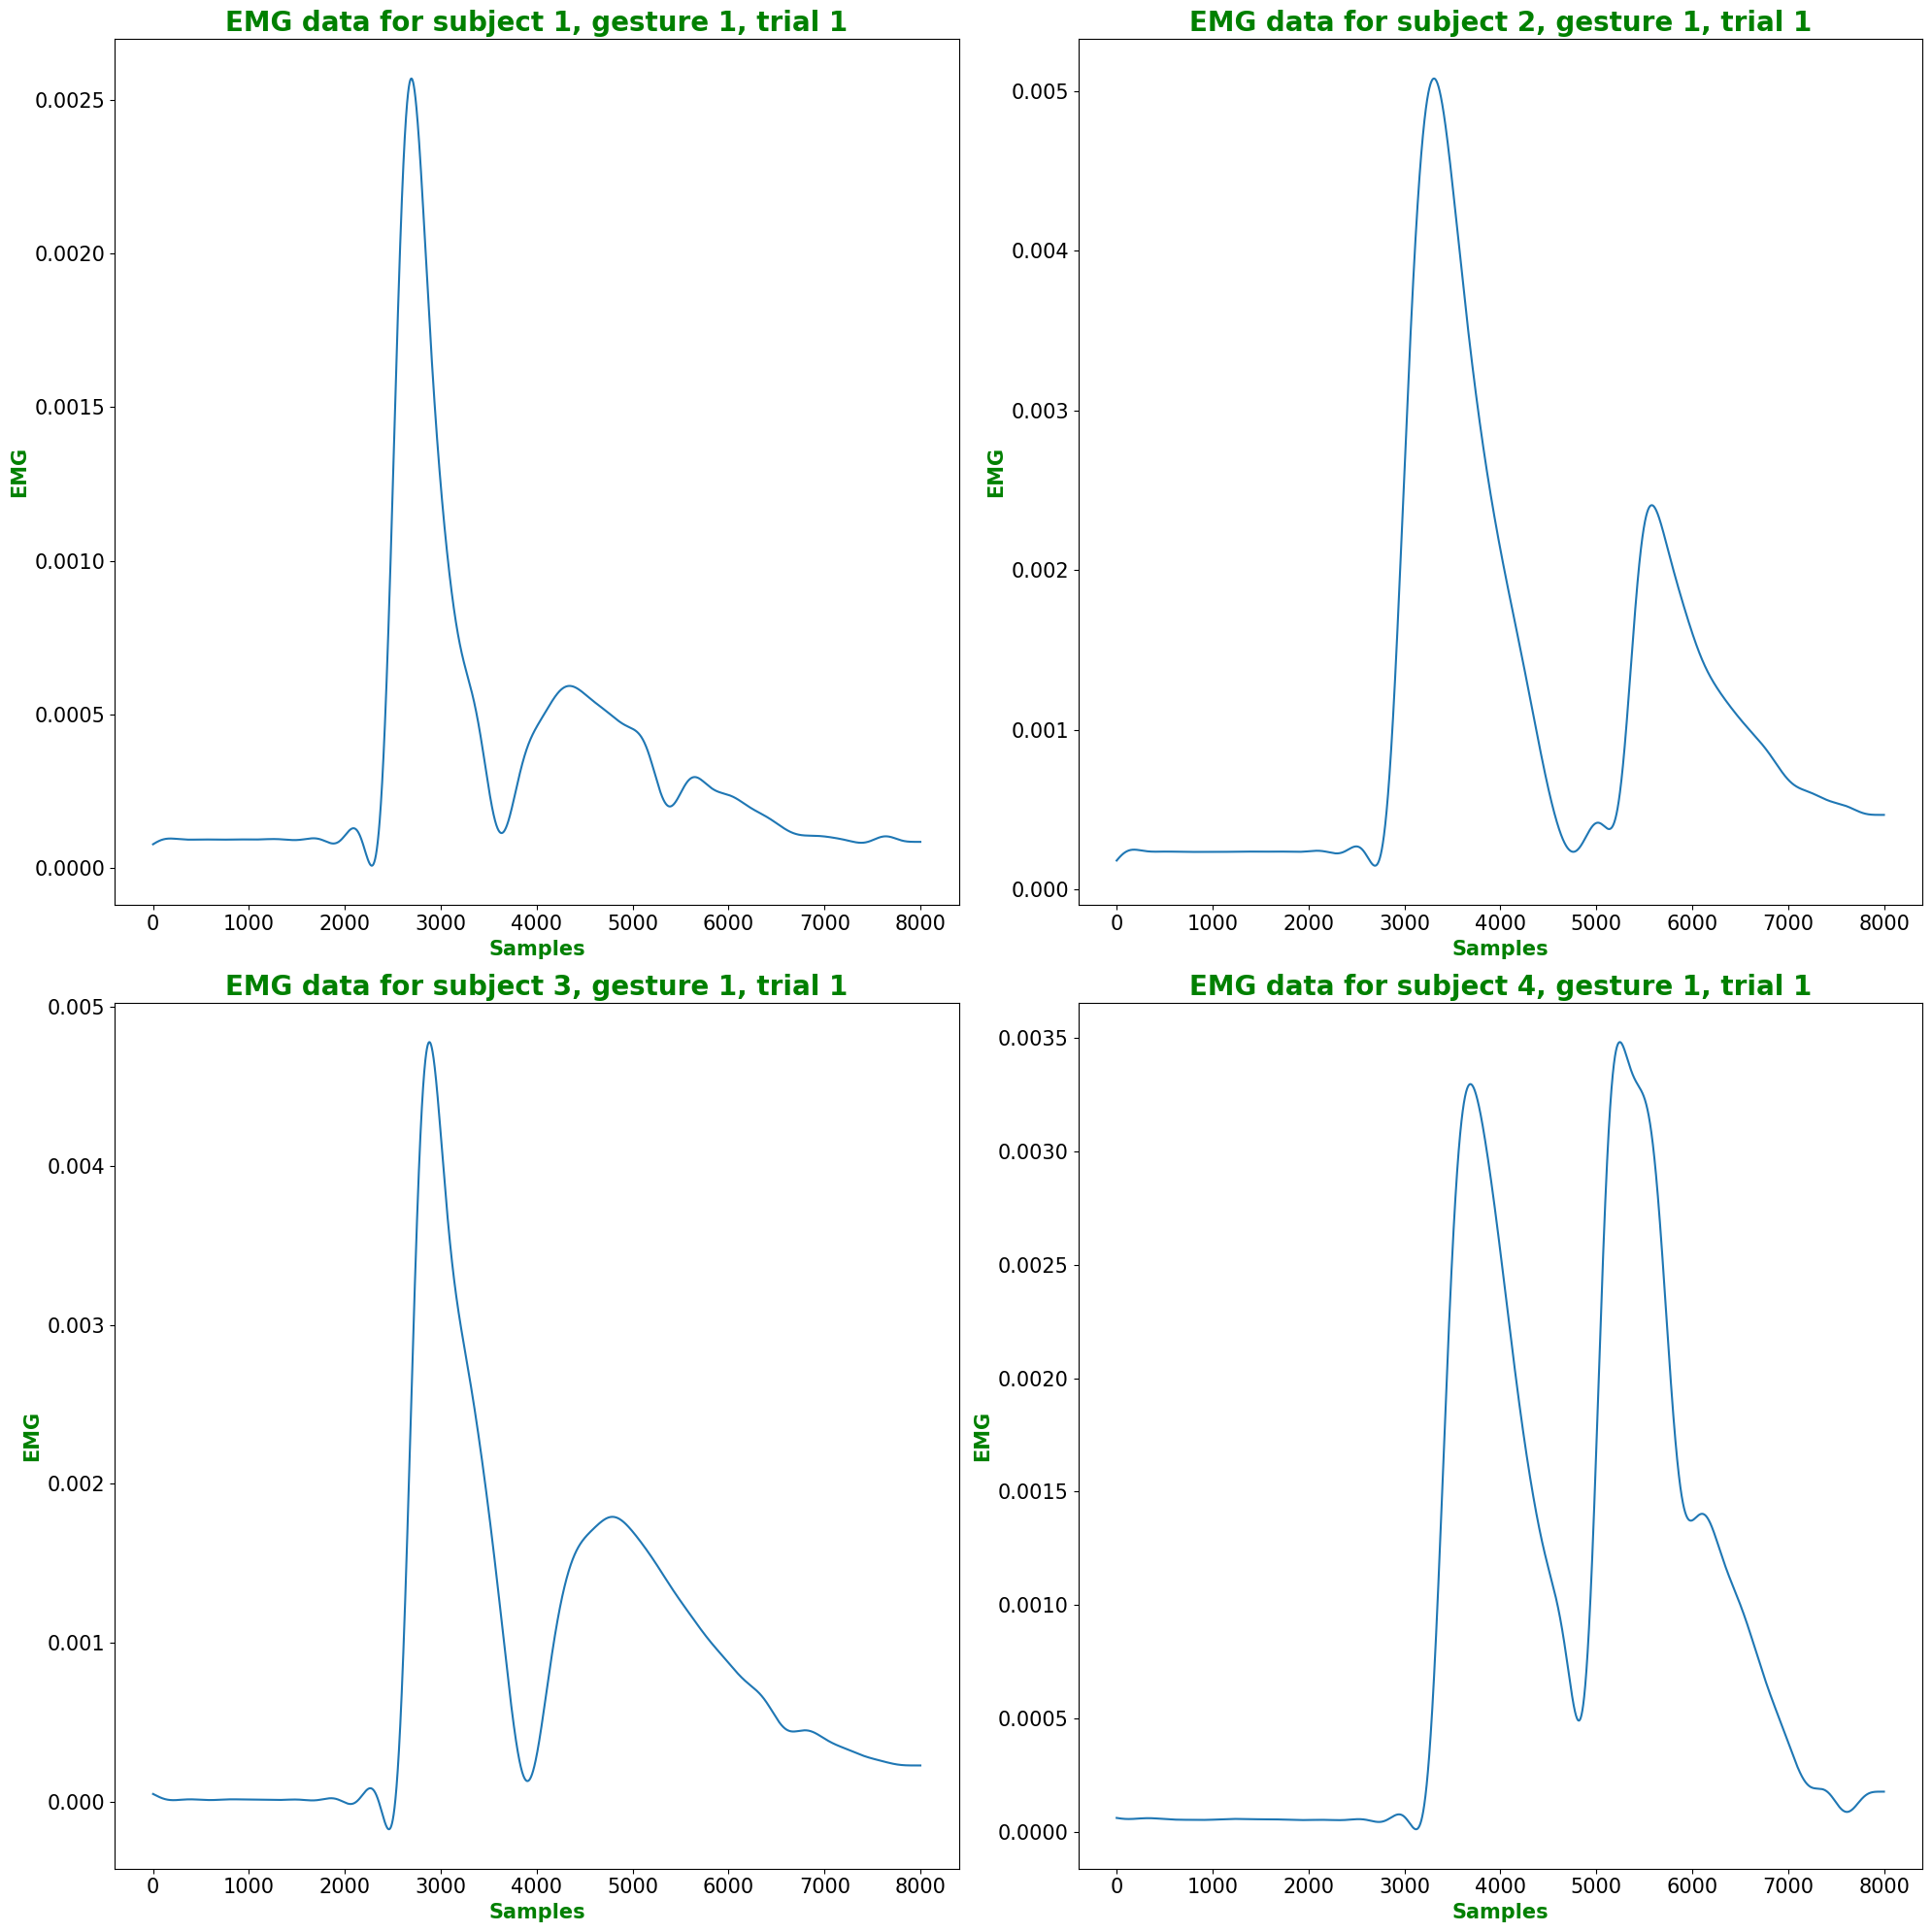

In [188]:
# visualize one of the sheets
fig, axs = plt.subplots(2,2, figsize=(20,20))
axs = axs.ravel()
# set resolution
fig.set_dpi(100)
for i, ax in enumerate(axs):
    ax.plot(df[f'{i+1}.1.1'])
    ax.set_title(f'EMG data for subject {i+1}, gesture 1, trial 1', fontsize=20, fontweight='bold', color='green')
    ax.set_xlabel('Samples', fontsize=15, fontweight='bold', color='green')
    ax.set_ylabel('EMG', fontsize=15, fontweight='bold', color='green')
    # set tick size
    ax.tick_params(axis='both', which='major', labelsize=15)
    
plt.tight_layout()
plt.show()

In [189]:
# error in the data: # the record 8.1.2 has a single ' ' value at the end
# so we need to remove it
df['8.1.2'] = df['8.1.2'].drop(df['8.1.2'].index[-1])

## We will select two features, namely 'peak magnitude' and 'time to peak' to train our model.

In [190]:
# create a new dataframe with only the peak magnitudes and time to peak
# for each subject, gesture, and trial
df_w_features = pd.DataFrame(columns=['subject', 'gesture', 'trial', 'peak_mag', 'time_to_peak'])
for i in range(1,10):
    for j in range(1,3):
        for k in range(1,3):
            # concat
            temp = df[f'{i}.{j}.{k}']
            temp = temp.iloc[:,0] 
            
            # the record 8.1.2 has a single ' ' value at the end, so drop it
            if i == 8 and j == 1 and k == 2:
                temp = temp.drop(temp.index[-1])

            # find peak magnitude and time to peak
            height = (temp.max() - temp.min())*0.3
            peaks, _ = find_peaks(temp, distance=500, height=height)

            # if only one peak is found, keep it, else keep the first peak
            peak = peaks[0]
            # find peak magnitude
            peak_mag = temp[peak]
            temp_df = temp_df.dropna()

            # create a temporary dataframe
            temp_df = pd.DataFrame([[i, j, k, peak_mag, peak]], columns=['subject', 'gesture', 'trial', 'peak_mag', 'time_to_peak'])
            # concat 
            df_w_features = pd.concat([df_w_features, temp_df])

df_w_features.head()

/var/folders/32/v931fsbd4wz17cqggkxv2txh0000gn/T/ipykernel_1863/3072280553.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_w_features = pd.concat([df_w_features, temp_df])


,subject,gesture,trial,peak_mag,time_to_peak
0,1,1,1,0.002569,2693
0,1,1,2,0.000899,2727
0,1,2,1,0.007755,3552
0,1,2,2,0.006925,3116
0,2,1,1,0.005080,3309


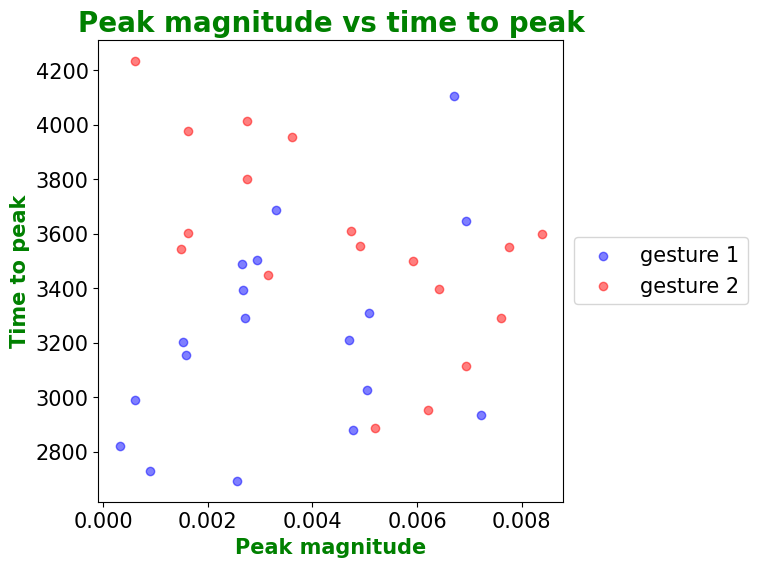

In [191]:
# plot the seleted features as a scatter plot for two gestures
fig, ax = plt.subplots(figsize=(6,6))

# set resolution
fig.set_dpi(100)

# plot the scatter plot
ax.scatter(df_w_features[df_w_features['gesture']==1]['peak_mag'], 
           df_w_features[df_w_features['gesture']==1]['time_to_peak'], 
           color='blue', label='gesture 1', alpha=0.5)

ax.scatter(df_w_features[df_w_features['gesture']==2]['peak_mag'],
              df_w_features[df_w_features['gesture']==2]['time_to_peak'], 
              color='red', label='gesture 2', alpha=0.5)

# set labels
ax.set_xlabel('Peak magnitude', fontsize=15, fontweight='bold', color='green')
ax.set_ylabel('Time to peak', fontsize=15, fontweight='bold', color='green')
ax.set_title('Peak magnitude vs time to peak', fontsize=20, fontweight='bold', color='green')

# set tick size
ax.tick_params(axis='both', which='major', labelsize=15)

# set legend outside the plot
ax.legend(fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [213]:
# using machine learning to classify the gestures based on the selected features
# import the necessary libraries
# we'll use cross validation to evaluate the model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
# import the classifier support vector machine
from sklearn.svm import SVC

# create the feature matrix
X = df_w_features[['peak_mag', 'time_to_peak']].values
# create the target vector
y = df_w_features['gesture'].astype(int).values

# create the classifier
clf = SVC(kernel='linear', C=1.0, random_state=0)

# Choose the number of folds (k)
num_folds = 10

# Create a k-fold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Perform cross-validation and get the accuracy scores
scores = cross_val_score(clf, X, y, cv=kfold)

# cross validation
print(f'Cross validation scores: {scores}')
print(f'Average cross validation score: {np.mean(scores)}')
print(f'Standard deviation of cross validation scores: {np.std(scores)}')

Cross validation scores: [0.5        0.5        1.         0.5        0.75       0.75
 1.         0.66666667 0.33333333 1.        ]
Average cross validation score: 0.7
Standard deviation of cross validation scores: 0.23033791601808756
